# Geospatial Instance Segmentation with TorchGeo + Mask R-CNN  
### NWPU VHR-10 (Very High Resolution, 10 classes)

**Goal for this workshop**

By the end, you'll be able to:

1. Load the NWPU VHR-10 dataset from TorchGeo (remote sensing, 10 object classes).
2. Explore images, bounding boxes, and **instance masks**.
3. Build a Mask R-CNN model (from torchvision) for **instance segmentation**.
4. Train on a small subset (for speed) and visualize predictions.

We'll use:

- [TorchGeo](https://github.com/torchgeo/torchgeo) for geospatial dataset handling.
- [torchvision](https://pytorch.org/vision/stable/models.html) Mask R-CNN for instance segmentation.


## 0. Environment setup

> Run this once at the top of your notebook.

⚠️ **Warning for instructors**:

- VHR-10 needs the `datasets` extra, plus `pycocotools` for COCO-style annotations.
- Always request a GPU runtime in Colab (T4 is enough).

💡 **Idea**: Have students run the `pip` cell themselves so they see what libraries are used.


In [ ]:
# If you're on Colab, uncomment this cell:
!pip install -q "torchgeo[datasets]" torch torchvision matplotlib

import torch
import torchvision
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

from torchgeo.datasets import VHR10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# 🧪 Practice 0:
# 1. Run this cell and see if you're on CPU or GPU.
# 2. If you have a GPU: print(torch.cuda.device_count()) to see how many devices are available.

print("CUDA device count:", torch.cuda.device_count())


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.5/240.5 kB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 827.9/827.9 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 106.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 1. Load and explore the VHR-10 dataset

VHR-10 (NWPU VHR-10) is a **very high resolution (0.08–2 m)** remote sensing dataset with:

- 800 images total  
  - 650 "positive" images (contain at least one object)  
  - 150 "negative" images (no objects)  
- 10 object classes: airplane, ship, storage tank, baseball diamond, tennis court, basketball court,
  ground track field, harbor, bridge, vehicle.

TorchGeo provides:

- images as tensors (C, H, W)
- COCO-style annotations converted into `boxes`, `labels`, and `masks`.

⚠️ **Important**:

- Use `split="positive"` for detection/segmentation (only positives have annotations).


In [ ]:
root = "data"  # change if you want
ds = VHR10(root=root, split="positive", download=True, checksum=False)
print("Dataset length (positive images):", len(ds))

sample = ds[0]
print("Keys in one sample:", sample.keys())
print("Image shape:", sample["image"].shape)  # (C, H, W)
print("Boxes shape:", sample["bbox_xyxy"].shape)
print("Labels shape:", sample["label"].shape)
print("Has masks:", "mask" in sample)


100%|██████████| 76.8M/76.8M [00:00<00:00, 214MB/s]
100%|██████████| 1.27M/1.27M [00:00<00:00, 160MB/s]

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Dataset length (positive images): 650
Keys in one sample: dict_keys(['image', 'label', 'bbox_xyxy', 'mask'])
Image shape: torch.Size([3, 808, 958])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
Has masks: True


### Visualize an image with ground truth boxes & masks

TorchGeo's `plot` method is built in for VHR-10 and can display:

- RGB image  
- bounding boxes  
- masks (if present)  

This is perfect to see what **instance segmentation** labels look like.


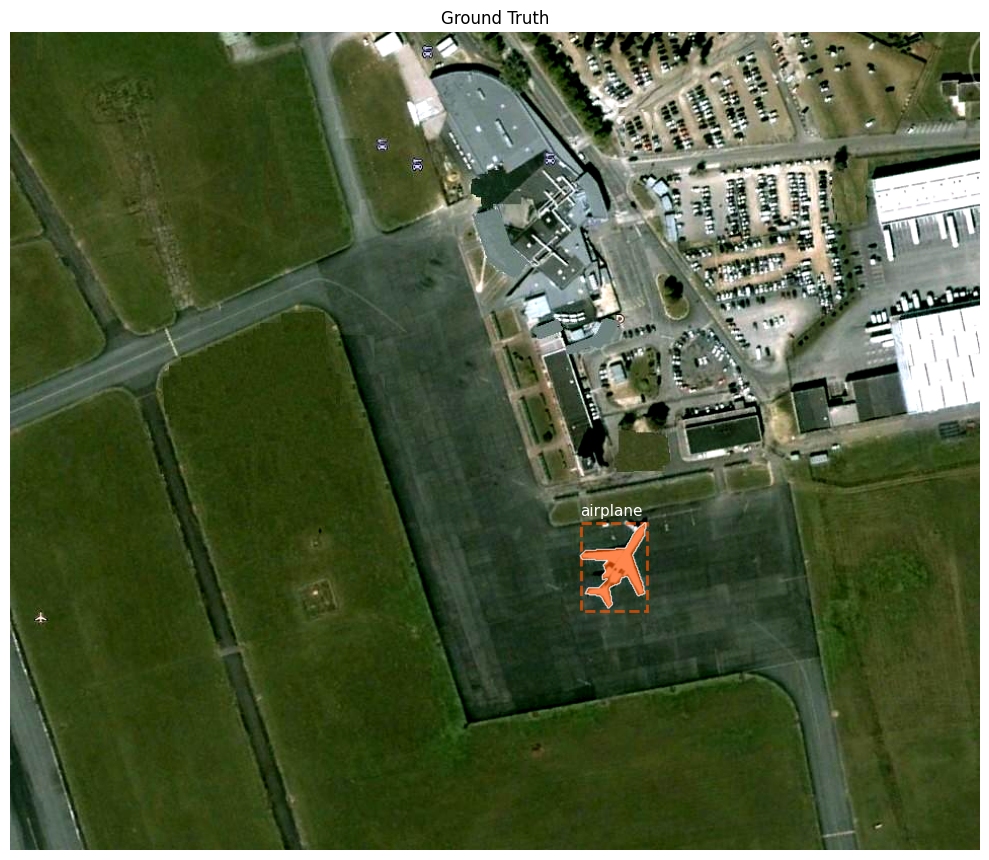

In [ ]:
ds.plot(sample)  # draws image with GT boxes + masks
plt.show()

# 🧪 Practice 1:
# 1. Pick a random index, e.g. idx = 42, and visualize that sample with ds.plot(ds[idx]).
# 2. Print the number of objects in that image: len(sample["labels"]).

# Example (uncomment):
# idx = 42
# sample = ds[idx]
# print("Number of objects:", len(sample["labels"]))
# ds.plot(sample); plt.show()


## 2. Simple preprocessing & DataLoader

Mask R-CNN in torchvision expects:

- images as `float32` tensors in **[0, 1]** range
- a **list of images** (variable size allowed)
- a **list of target dicts**, each with:
  - `boxes`: `[N, 4]`
  - `labels`: `[N]`
  - `masks` (optional): `[N, H, W]`

TorchGeo already:

- returns `image` as float tensor (0–255)
- gives `boxes`, `labels`, `masks` per sample

We’ll:

1. Normalize `image / 255.0` using a small transform function.
2. Use a custom `collate_fn` that returns a **list of samples** (no stacking), since image sizes differ.


In [ ]:
def transform_to_unit_range(sample: dict) -> dict:
    # Normalize image to [0, 1] range.
    image = sample["image"] / 255.0
    sample["image"] = image
    return sample

# Recreate dataset with transform
ds = VHR10(root=root, split="positive", download=False, transforms=transform_to_unit_range)
sample = ds[0]
print("Image min/max after normalization:",
      sample["image"].min().item(), sample["image"].max().item())

def collate_fn(batch):
    # Simple collate function for detection / instance segmentation.
    # Input: list of samples (dicts)
    # Output: same list (we handle conversion in the training loop).
    return batch

# For speed in workshop, use a small subset (e.g. first 100 images)
subset_indices = list(range(100))
train_dataset = Subset(ds, subset_indices)

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn,
)

print("Batches in train_loader:", len(train_loader))

# 🧪 Practice 2:
# Inspect one batch and print image shapes:
# batch = next(iter(train_loader))
# for i, s in enumerate(batch):
#     print(i, s["image"].shape)


loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
Image min/max after normalization: 0.0 1.0
Batches in train_loader: 50


## 3. Build Mask R-CNN (torchvision)

We’ll use `maskrcnn_resnet50_fpn` from torchvision:

- Backbone: ResNet-50 + FPN
- Detection head: region proposals + class & box prediction
- Segmentation head: mask prediction per instance

VHR-10 has **10 classes + background**, and `VHR10.categories` includes `'background'` at index 0.


In [ ]:
from torchvision.models.detection import (
    maskrcnn_resnet50_fpn,
    MaskRCNN_ResNet50_FPN_Weights,
)
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Get class count from dataset (handle Subset)
if isinstance(train_dataset, Subset):
    base_ds = train_dataset.dataset  # underlying VHR10
else:
    base_ds = train_dataset

num_classes = len(base_ds.categories)
print("Number of classes (including background):", num_classes)

# 1) Start from COCO-pretrained weights (good initialization)
weights = MaskRCNN_ResNet50_FPN_Weights.COCO_V1
model = maskrcnn_resnet50_fpn(weights=weights)
model.to(device)

# 2) Replace classification head (box predictor)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# 3) Replace mask head
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(
    in_features_mask,
    hidden_layer,
    num_classes,
)

model.to(device)
print("Model ready.")

# ⚠️ Note: We keep most COCO-trained weights and only reinitialize the last heads.


Number of classes (including background): 11
Model ready.


## 4. Training loop (mini version for workshop)

For each batch:

1. Convert list of samples → `images` (list of tensors) + `targets` (list of dicts).
2. Forward pass: `loss_dict = model(images, targets)`.
3. Sum loss terms and backprop.

We’ll only train for **1–2 epochs** on a **subset of 100 images** so it runs quickly.


In [ ]:
# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        # batch is a list of samples (dicts)
        images = [b["image"].to(device) for b in batch]

        targets = []
        for b in batch:
            target = {
                "boxes": b["bbox_xyxy"].to(device),
                "labels": b["label"].to(device),
            }
            if "mask" in b:
                target["masks"] = b["mask"].to(device)
            targets.append(target)

        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(
                f"Epoch [{epoch+1}/{num_epochs}] "
                f"Batch [{batch_idx+1}/{len(train_loader)}] "
                f"Loss: {loss.item():.4f}"
            )

    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average loss: {avg_loss:.4f}")

# 🧪 Practice 3:
# - Change num_epochs to 1 or 3 and observe training time and loss.
# - Change batch_size in the DataLoader to 4 and see if GPU memory is okay.


Epoch [1/2] Batch [10/50] Loss: 0.9551
Epoch [1/2] Batch [20/50] Loss: 0.8104
Epoch [1/2] Batch [30/50] Loss: 1.2225
Epoch [1/2] Batch [40/50] Loss: 1.1001
Epoch [1/2] Batch [50/50] Loss: 1.4788
Epoch [1/2] Average loss: 1.1907
Epoch [2/2] Batch [10/50] Loss: 0.5504
Epoch [2/2] Batch [20/50] Loss: 0.5098
Epoch [2/2] Batch [30/50] Loss: 0.9163
Epoch [2/2] Batch [40/50] Loss: 0.4485
Epoch [2/2] Batch [50/50] Loss: 0.5293
Epoch [2/2] Average loss: 0.6151


## 5. Inference & visualization

Now we’ll:

1. Take a few samples from the dataset.
2. Run `model` in `eval()` mode **without targets** → predictions.
3. Plot:
   - image
   - ground-truth boxes
   - predicted boxes + masks + scores

We’ll reuse TorchGeo’s `plot` method and feed predictions back into the sample dict using keys:

- `prediction_boxes`
- `prediction_labels`
- `prediction_scores`
- `prediction_masks`


In [ ]:
sample

{'image': tensor([[[0.3059, 0.3059, 0.3098,  ..., 0.3765, 0.3686, 0.3647],
          [0.3020, 0.3020, 0.3098,  ..., 0.3804, 0.3725, 0.3686],
          [0.2941, 0.2980, 0.3059,  ..., 0.3804, 0.3686, 0.3569],
          ...,
          [0.4431, 0.4431, 0.4471,  ..., 0.3373, 0.3333, 0.3333],
          [0.4431, 0.4431, 0.4471,  ..., 0.3373, 0.3333, 0.3294],
          [0.4392, 0.4431, 0.4431,  ..., 0.3412, 0.3333, 0.3294]],
 
         [[0.3490, 0.3490, 0.3529,  ..., 0.4275, 0.4196, 0.4157],
          [0.3451, 0.3451, 0.3529,  ..., 0.4314, 0.4235, 0.4196],
          [0.3333, 0.3373, 0.3451,  ..., 0.4314, 0.4196, 0.4078],
          ...,
          [0.4941, 0.4941, 0.4980,  ..., 0.3569, 0.3529, 0.3529],
          [0.4941, 0.4941, 0.4980,  ..., 0.3569, 0.3529, 0.3490],
          [0.4902, 0.4941, 0.4941,  ..., 0.3608, 0.3529, 0.3490]],
 
         [[0.1922, 0.1922, 0.1961,  ..., 0.3098, 0.3098, 0.3059],
          [0.1882, 0.1882, 0.1961,  ..., 0.3137, 0.3137, 0.3098],
          [0.1882, 0.1922, 0.20

In [ ]:
sample_for_plot

{'image': tensor([[[0.3059, 0.3059, 0.3098,  ..., 0.3765, 0.3686, 0.3647],
          [0.3020, 0.3020, 0.3098,  ..., 0.3804, 0.3725, 0.3686],
          [0.2941, 0.2980, 0.3059,  ..., 0.3804, 0.3686, 0.3569],
          ...,
          [0.4431, 0.4431, 0.4471,  ..., 0.3373, 0.3333, 0.3333],
          [0.4431, 0.4431, 0.4471,  ..., 0.3373, 0.3333, 0.3294],
          [0.4392, 0.4431, 0.4431,  ..., 0.3412, 0.3333, 0.3294]],
 
         [[0.3490, 0.3490, 0.3529,  ..., 0.4275, 0.4196, 0.4157],
          [0.3451, 0.3451, 0.3529,  ..., 0.4314, 0.4235, 0.4196],
          [0.3333, 0.3373, 0.3451,  ..., 0.4314, 0.4196, 0.4078],
          ...,
          [0.4941, 0.4941, 0.4980,  ..., 0.3569, 0.3529, 0.3529],
          [0.4941, 0.4941, 0.4980,  ..., 0.3569, 0.3529, 0.3490],
          [0.4902, 0.4941, 0.4941,  ..., 0.3608, 0.3529, 0.3490]],
 
         [[0.1922, 0.1922, 0.1961,  ..., 0.3098, 0.3098, 0.3059],
          [0.1882, 0.1882, 0.1961,  ..., 0.3137, 0.3137, 0.3098],
          [0.1882, 0.1922, 0.20

In [ ]:
model.eval()

indices_to_show = [0, 10, 20]  # change as you like

for idx in indices_to_show:
    sample = ds[idx]

    image = sample["image"].to(device)
    with torch.no_grad():
        prediction_list = model([image])
    prediction = prediction_list[0]

    # Prepare dict for plotting
    sample_for_plot = {
        "image": sample["image"].cpu(),
        "bbox_xyxy": sample["bbox_xyxy"].cpu(),
        "label": sample["label"].cpu(),
    }

    if "mask" in sample:
        sample_for_plot["masks"] = sample["mask"].cpu()

    # Copy predictions
    sample_for_plot["prediction_boxes"] = prediction["boxes"].cpu()
    sample_for_plot["prediction_labels"] = prediction["labels"].cpu()
    sample_for_plot["prediction_scores"] = prediction["scores"].cpu()

    if "masks" in prediction:
        # prediction["masks"]: [N, 1, H, W] → [N, H, W]
        sample_for_plot["prediction_masks"] = prediction["masks"].cpu().squeeze(1)

    fig = ds.plot(sample_for_plot, show_feats="both")
    plt.suptitle(f"Sample {idx} — GT vs. Mask R-CNN predictions")
    plt.show()

# 🧪 Practice 4:
# Add a confidence threshold, e.g. keep only scores >= 0.5:
#
# scores = prediction["scores"]
# keep = scores >= 0.5
# sample_for_plot["prediction_boxes"] = prediction["boxes"][keep].cpu()
# sample_for_plot["prediction_labels"] = prediction["labels"][keep].cpu()
# sample_for_plot["prediction_scores"] = scores[keep].cpu()
# sample_for_plot["prediction_masks"] = prediction["masks"][keep].cpu().squeeze(1)
#
# Try different thresholds (0.3, 0.7, 0.9) and see how the visualization changes.


## 6. Simple evaluation: box IoU, precision, recall

We’ll compute a **very small** evaluation:

1. Use a tiny validation set (e.g. 20 images).
2. For each image:
   - Run the model in `eval()` mode.
   - Filter predictions by score (e.g. ≥ 0.5).
   - Match predicted boxes to ground-truth boxes using IoU ≥ 0.5 and same class.
3. Count:
   - TP (true positives): matched predictions
   - FP (false positives): predictions that didn’t match any GT
   - FN (false negatives): GT objects with no matching prediction

Then compute:

- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN)

This is **not** full COCO-style mAP, but it’s easy to understand and enough for a workshop.


In [ ]:
from torchvision.ops import box_iou

# Build a tiny validation set: next 20 images after the training subset
val_indices = list(range(100, min(120, len(ds))))
val_dataset = Subset(ds, val_indices)

val_loader = DataLoader(
    val_dataset,
    batch_size=1,        # easier for teaching + matching logic
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn,
)

def evaluate_model(model, data_loader, score_thresh=0.5, iou_thresh=0.5):
    model.eval()
    total_tp = 0
    total_fp = 0
    total_fn = 0

    with torch.no_grad():
        for batch in data_loader:
            # batch is a list of size 1 because batch_size=1
            sample = batch[0]
            image = sample["image"].to(device)
            gt_boxes = sample["boxes"].to(device)
            gt_labels = sample["labels"].to(device)

            # Forward pass (no targets → predictions)
            outputs = model([image])[0]
            pred_boxes = outputs["boxes"].to(device)
            pred_labels = outputs["labels"].to(device)
            scores = outputs["scores"].to(device)

            # 1) Filter predictions by score
            keep = scores >= score_thresh
            pred_boxes = pred_boxes[keep]
            pred_labels = pred_labels[keep]

            if pred_boxes.numel() == 0:
                # no predictions at this threshold
                total_fn += gt_boxes.shape[0]
                continue

            # 2) Compute IoU between all GT and predicted boxes
            ious = box_iou(gt_boxes, pred_boxes)  # [num_gt, num_pred]

            # 3) Greedy matching based on max IoU per GT
            matched_pred = set()
            tp = 0

            for gt_idx in range(gt_boxes.shape[0]):
                # Best predicted box for this GT
                iou_row = ious[gt_idx]
                best_iou, best_pred_idx = iou_row.max(0)

                # Check if it’s a good match (IoU + same label)
                if (
                    best_iou >= iou_thresh
                    and best_pred_idx.item() not in matched_pred
                    and pred_labels[best_pred_idx] == gt_labels[gt_idx]
                ):
                    tp += 1
                    matched_pred.add(best_pred_idx.item())

            fp = pred_boxes.shape[0] - len(matched_pred)
            fn = gt_boxes.shape[0] - tp

            total_tp += tp
            total_fp += fp
            total_fn += fn

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0

    return {
        "tp": total_tp,
        "fp": total_fp,
        "fn": total_fn,
        "precision": precision,
        "recall": recall,
    }

metrics = evaluate_model(model, val_loader, score_thresh=0.5, iou_thresh=0.5)
print("Evaluation on small validation set:")
print(metrics)


In [ ]:
# 🧪 Practice 5:
# 1. Try different score thresholds: 0.3, 0.5, 0.7.
#    metrics_03 = evaluate_model(model, val_loader, score_thresh=0.3)
#    metrics_07 = evaluate_model(model, val_loader, score_thresh=0.7)
# 2. Compare precision and recall:
#    - What happens to precision when you increase the threshold?
#    - What happens to recall?
#
# 3. (Discussion) How would you choose a threshold for a *real* application?


## 6. Wrap-up & extensions

**Key takeaways:**

1. **Geospatial datasets** can be handled with TorchGeo, which provides:
   - dataset classes
   - metadata
   - plotting helpers
2. **Instance segmentation** = object detection + per-instance mask (Mask R-CNN).
3. Mask R-CNN from torchvision works on remote sensing data with:
   - proper image scaling to `[0, 1]`
   - correct `num_classes`
   - a custom `collate_fn` for variable-size images.

**Extensions:**

- Use TorchGeo’s `InstanceSegmentationTask` + PyTorch Lightning for cleaner training and metrics.
- Add data augmentations (random flip, resize, color jitter) and study their effect.
- Compare with:
  - object detection only (Faster R-CNN)
  - semantic segmentation models (no instance separation)
  - YOLO-style models trained on VHR-10.
